Monitoring COVID-19 Infections through Wastewater Surveillance
CMPSC 190DD/197A Project, Fall 2020
Nick Bachelder, Anton de la Fuente, Zoe Holzer 

PART A: 
1. Using the model dynamics described in the previous section, and all the given and chosen parameters, simulate the behavior of the disease for 120 days for this single leaf node.

In [145]:
import numpy as np
part1 = np.load("part1a.npz")
part1.files
Ic_0 = part1["Ic_0"]
N = part1["N"]
gamma = part1["gamma"]
Lc = part1["Lc"]
Svc_0 = part1["Svc_0_pmf"]

In [146]:
import pandas as pd
S_0 = N-(Ic_0.sum())
I_0 = Ic_0.sum()
R_0 = 0
data = pd.DataFrame(Svc_0)

In [147]:
import random 
from random import Random
random.seed(a=None, version=2)
B0c = []
B1c = []
B2c = []
B3c = []
for i in range(4):
    B0c.append(random.uniform(0, 0.25))
    B1c.append(random.uniform(0.25, 0.5))
    B2c.append(random.uniform(0.5, 0.75))
    B3c.append(random.uniform(0.75, 1.0))
    Bvc = np.array([B0c, B1c, B2c, B3c])
for i in range(4):
    Bvc[i].sort()
Bvc = pd.DataFrame(Bvc)

In [148]:
def S_rate(Svc, Ic, N, Bvc, gamma):
    """Calculate the rate of change of suceptible group split by vulnerability and comorbidity, return a
    tuple where the first element is split on both categories, and the second element only split by comorbidity"""
    #This makes sure that once population hits 0 it doesn't affect the differential
    Svc[Svc < 0] = 0
    dSvcdt = ((Bvc * Svc * Ic)*-1)/N
    return dSvcdt

In [149]:
def I_rate(dSvcdt, Ic, gamma):
    """This function takes in the rate of change of S, sums along the vulnerability axis, and subtracts 
    Ic*gamma"""
    Ic[Ic < 0]= 0
    dIcdt = -dSvcdt.sum() - gamma*Ic
    return dIcdt

In [150]:
def R_rate(Ic, gamma):
    Ic[Ic < 0]= 0
    dRdt = gamma * Ic.sum()
    return dRdt

In [151]:
def SIR_rates(Svc, Ic, N, Bvc, gamma):
    dSvcdt = S_rate(Svc, Ic, N, Bvc, gamma)
    dIcdt = I_rate(dSvcdt, Ic, gamma)
    dRdt = R_rate(Ic, gamma)
    return dSvcdt, dIcdt, dRdt

In [152]:
def L_rate(Ic, Lc, N):
    Lrate=(Ic*Lc)/N
    return Lrate

In [153]:
def simulation(t, Svc, Ic, N, Bvc, gamma, Lc, I_0):
    I = I_0
    R = 0
    S = Svc.sum().sum()
    SvcOverTime=[]
    IcOvertime=[]
    LOverTime=[]
    simulation = [[S, I, R]]
    for i in range(t):
        rates = SIR_rates(Svc, Ic, N, Bvc, gamma)
        Lrate=L_rate(Ic, Lc, N)
        Svc = Svc + rates[0]
        S = Svc.sum().sum()
        Ic = Ic + rates[1]
        I = Ic.sum()
        R = R + rates[2]
        L=Lrate.sum()
        simulation.append([S, I, R])
        SvcOverTime.insert(i,Svc)
        IcOvertime.insert(i,Ic)
        LOverTime.insert(i,L)
    results = pd.DataFrame(simulation, columns = ["S", "I", "R"])
    return results, SvcOverTime, IcOvertime, LOverTime

In [155]:
#The Svc data multiplied by the population to get raw population values split in both dimensions
t=120
Svc = pd.DataFrame(Svc_0) * (N - I_0)
Ic = Ic_0
sim = simulation(t, Svc, Ic, N, Bvc, gamma, Lc,I_0)

2. Plot Sv,c and Ic values over time. (You can plot all Sv,c on the same plot. Same for Ic.). Also plot the overall S, I, R and L values.

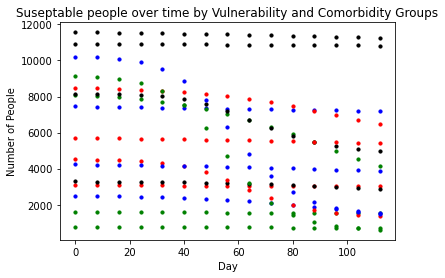

In [156]:
import matplotlib.pyplot as plt
fig,ax=plt.subplots(sharex=True)
for a in range(0,120,8):
    for b in range(0,4):
        ax.scatter(a,sim[1][a][b][0],c='black',s=10)
        ax.scatter(a,sim[1][a][b][1],c='red',s=10)
        ax.scatter(a,sim[1][a][b][2],c='blue',s=10)
        ax.scatter(a,sim[1][a][b][3],c='green',s=10)
plt.title('Suseptable people over time by Vulnerability and Comorbidity Groups')
plt.ylabel('Number of People')
plt.xlabel('Day')
plt.show()

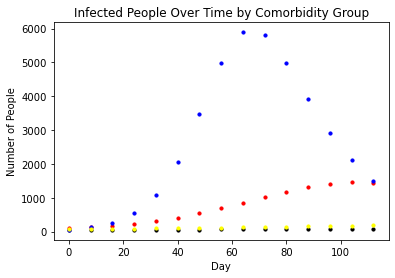

In [157]:
fig,ax=plt.subplots(sharex=True)
for a in range(0,120,8):
    ax.scatter(a,sim[2][a][0],c='black',s=10)
    ax.scatter(a,sim[2][a][1],c='red',s=10)
    ax.scatter(a,sim[2][a][2],c='blue',s=10)
    ax.scatter(a,sim[2][a][3],c='yellow',s=10) 
plt.title('Infected People Over Time by Comorbidity Group')
plt.ylabel('Number of People')
plt.xlabel('Day')
plt.show()

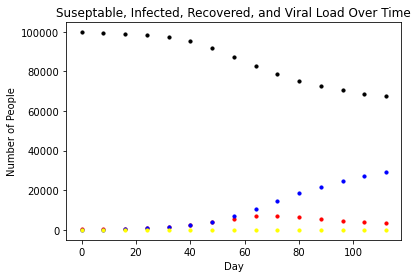

In [158]:
fig,ax=plt.subplots(sharex=True)
SIR=np.array(sim[0])
for a in range(0,120,8):
    ax.scatter(a,SIR[a][0],c='black',s=10)
    ax.scatter(a,SIR[a][1],c='red',s=10)
    ax.scatter(a,SIR[a][2],c='blue',s=10)
    ax.scatter(a,sim[3][a],c='yellow',s=10)
plt.title('Suseptable, Infected, Recovered, and Viral Load Over Time')
plt.ylabel('Number of People')
plt.xlabel('Day')
plt.show()

**3. Do the shapes of S, I, R look similar to what you expected? Which of these plots is the “curve” people refer to when they say “flatten the curve”?**

The shapes of the model look about right except that we were not expecting the huge difference in scale between S and I or R after 120 days. The overall shape however is what we expected based off of what we learned in class and off of over COVID models currently available. Moreover, it is clear that the comorbidity groups largely impact the infected population over time, which makes perfect sense. When people say 'flatten the curve,' they are refering to the infected population curve (in blue on the last plot).

**4. Do you observe that some Sv,c compartments converged to zero while others converged to a positive value? Why do you think that is?**

Yes, we did observe some compartments converging to positive values other then zero. We believe that is because specific βv,c values have a large affect on the overall model, especially because it is the reciprocal of the typical time until an infected person recovers, making it play a large part on the time series.

In [159]:
## Print the percentages of population that never got infected for all compartments (i.e. all values
## of v and c)

OriginalSvcPopulations = pd.DataFrame(Svc_0) * (N - I_0)
SvcFinalDay = sim[1][119]
PercentNotInfectedvc = SvcFinalDay / OriginalSvcPopulations
PercentNotInfectedvc

,0,1,2,3
0,0.989626,0.865107,0.598556,0.970587
1,0.980598,0.735240,0.288750,0.944073
2,0.962461,0.594474,0.136460,0.904384
3,0.946235,0.473281,0.061052,0.879536


In [160]:
## Redo but multiply all Beta values by 1/4. How does this change plots?

BvcRedo = Bvc * (1/4)

Svc = pd.DataFrame(Svc_0) * (N - I_0)
Ic = Ic_0
I = I_0
S = Svc.sum().sum()
R = 0
simRedo = simulation(t, Svc, Ic, N, BvcRedo, gamma, Lc,I_0)

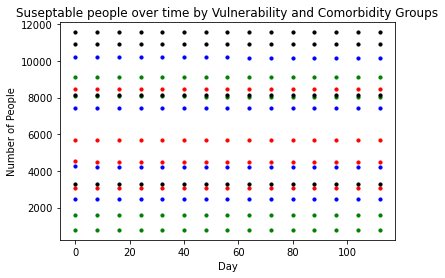

In [161]:
import matplotlib.pyplot as plt
fig,ax=plt.subplots(sharex=True)
for a in range(0,120,8):
    for b in range(0,4):
        ax.scatter(a,simRedo[1][a][b][0],c='black',s=10)
        ax.scatter(a,simRedo[1][a][b][1],c='red',s=10)
        ax.scatter(a,simRedo[1][a][b][2],c='blue',s=10)
        ax.scatter(a,simRedo[1][a][b][3],c='green',s=10)
plt.title('Suseptable people over time by Vulnerability and Comorbidity Groups')
plt.ylabel('Number of People')
plt.xlabel('Day')

plt.show()

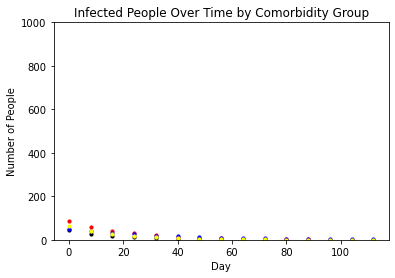

In [162]:
fig,ax=plt.subplots(sharex=True)
for a in range(0,120,8):
    ax.scatter(a,simRedo[2][a][0],c='black',s=10)
    ax.scatter(a,simRedo[2][a][1],c='red',s=10)
    ax.scatter(a,simRedo[2][a][2],c='blue',s=10)
    ax.scatter(a,simRedo[2][a][3],c='yellow',s=10) 
plt.ylim(0, 1000)

plt.title('Infected People Over Time by Comorbidity Group')
plt.ylabel('Number of People')
plt.xlabel('Day')

plt.show()

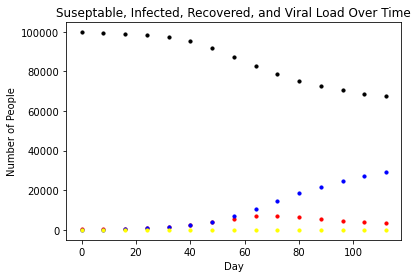

In [163]:
fig,ax=plt.subplots(sharex=True)
SIRRedo=simRedo[0]
for a in range(0,120,8):
    ax.scatter(a,SIR[a][0],c='black',s=10)
    ax.scatter(a,SIR[a][1],c='red',s=10)
    ax.scatter(a,SIR[a][2],c='blue',s=10)
    ax.scatter(a,simRedo[3][a],c='yellow',s=10)
    
plt.title('Suseptable, Infected, Recovered, and Viral Load Over Time')
plt.ylabel('Number of People')
plt.xlabel('Day')
plt.show()

What happened to the S, I, R plots? Did the “curve” flatten compared to the previous case?

The plots changed drastically dy reducing the beta rate. Since the disease was being spread at a much slower rate, all v,c groups declined in cases over time, and the curve most definetly 'flattened.'

In [164]:
## Print the percentages of population that never got infected withthese βv,c values.

OriginalSvcPopulations = pd.DataFrame(Svc_0) * (N - I_0)
SvcFinalDay = simRedo[1][119]
PercentNotInfectedvcRedo = SvcFinalDay / OriginalSvcPopulations

In [165]:
PercentNotInfectedvc ## Many less people in each group were infected at a lower beta value

,0,1,2,3
0,0.989626,0.865107,0.598556,0.970587
1,0.980598,0.735240,0.288750,0.944073
2,0.962461,0.594474,0.136460,0.904384
3,0.946235,0.473281,0.061052,0.879536


In [166]:
part2 = np.load("part1b.npz")
part2.files
Ic_0 = part2["Ic_0"]
N = part2["N"]
gamma = part2["gamma"]
Lc = part2["Lc"]
L_validation = part2["L_validation"]
L_test = part2["L_test"]
betas_validation = part2["betas_validation"]
SVC0=np.array([[0.5, 0.3, 0.1, 0.1]*5,[0.4, 0.3, 0.2, 0.1]*5,[0.3, 0.3, 0.3, 0.2]*5,[0.1, 0.2, 0.3, 0.4]*5])
SVC = pd.DataFrame(SVC0) * (N - I_0)
Ic= pd.DataFrame(Ic)
Ic=Ic.transpose()
Lc=pd.DataFrame([Lc]*20)
I_0 = Ic_0.sum()

In [173]:
#grid search
from sklearn.metrics import mean_squared_error
beta_grid=np.linspace(0,1,20)
print(beta_grid)
mmse=np.inf
L_mmse=np.nan
for beta in beta_grid:
    t=20
    simTrial=simulation(t, SVC, Ic, N, beta, gamma, Lc, I_0)
    local_mmse=np.inf
    print(simTrial[3])
    for L in simTrial[3]:
        mse = mean_squared_error(L_validation, simTrial[3])  
        (local_mmse) = (mse) if (mse < local_mmse) else (local_mmse)
    mmse = (local_mmse,L_mmse) if (local_mmse < mmse) else (mmse,L_mmse)

[0.         0.05263158 0.10526316 0.15789474 0.21052632 0.26315789
 0.31578947 0.36842105 0.42105263 0.47368421 0.52631579 0.57894737
 0.63157895 0.68421053 0.73684211 0.78947368 0.84210526 0.89473684
 0.94736842 1.        ]
[0    0.000282
1    0.000720
2    0.000714
3    0.001300
dtype: float64, 0     0.000262
1     0.000669
2     0.000663
3     0.001207
4     0.000000
5     0.000000
6     0.000000
7     0.000000
8     0.000000
9     0.000000
10    0.000000
11    0.000000
12    0.000000
13    0.000000
14    0.000000
15    0.000000
16    0.000000
17    0.000000
18    0.000000
19    0.000000
dtype: float64, 0     0.000243
1     0.000621
2     0.000616
3     0.001121
4     0.000000
5     0.000000
6     0.000000
7     0.000000
8     0.000000
9     0.000000
10    0.000000
11    0.000000
12    0.000000
13    0.000000
14    0.000000
15    0.000000
16    0.000000
17    0.000000
18    0.000000
19    0.000000
dtype: float64, 0     0.000226
1     0.000576
2     0.000572
3     0.001041
4     0.00

[0    0.000282
1    0.000720
2    0.000714
3    0.001300
dtype: float64, 0     0.000284
1     0.000703
2     0.000674
3     0.001228
4     0.000000
5     0.000000
6     0.000000
7     0.000000
8     0.000000
9     0.000000
10    0.000000
11    0.000000
12    0.000000
13    0.000000
14    0.000000
15    0.000000
16    0.000000
17    0.000000
18    0.000000
19    0.000000
dtype: float64, 0     0.000286
1     0.000685
2     0.000637
3     0.001159
4     0.000000
5     0.000000
6     0.000000
7     0.000000
8     0.000000
9     0.000000
10    0.000000
11    0.000000
12    0.000000
13    0.000000
14    0.000000
15    0.000000
16    0.000000
17    0.000000
18    0.000000
19    0.000000
dtype: float64, 0     0.000288
1     0.000669
2     0.000601
3     0.001095
4     0.000000
5     0.000000
6     0.000000
7     0.000000
8     0.000000
9     0.000000
10    0.000000
11    0.000000
12    0.000000
13    0.000000
14    0.000000
15    0.000000
16    0.000000
17    0.000000
18    0.000000
19    0.00

[0    0.000282
1    0.000720
2    0.000714
3    0.001300
dtype: float64, 0     0.000299
1     0.000725
2     0.000682
3     0.001241
4     0.000000
5     0.000000
6     0.000000
7     0.000000
8     0.000000
9     0.000000
10    0.000000
11    0.000000
12    0.000000
13    0.000000
14    0.000000
15    0.000000
16    0.000000
17    0.000000
18    0.000000
19    0.000000
dtype: float64, 0     0.000317
1     0.000730
2     0.000651
3     0.001185
4     0.000000
5     0.000000
6     0.000000
7     0.000000
8     0.000000
9     0.000000
10    0.000000
11    0.000000
12    0.000000
13    0.000000
14    0.000000
15    0.000000
16    0.000000
17    0.000000
18    0.000000
19    0.000000
dtype: float64, 0     0.000335
1     0.000735
2     0.000621
3     0.001131
4     0.000000
5     0.000000
6     0.000000
7     0.000000
8     0.000000
9     0.000000
10    0.000000
11    0.000000
12    0.000000
13    0.000000
14    0.000000
15    0.000000
16    0.000000
17    0.000000
18    0.000000
19    0.00

[0    0.000282
1    0.000720
2    0.000714
3    0.001300
dtype: float64, 0     0.000314
1     0.000748
2     0.000689
3     0.001255
4     0.000000
5     0.000000
6     0.000000
7     0.000000
8     0.000000
9     0.000000
10    0.000000
11    0.000000
12    0.000000
13    0.000000
14    0.000000
15    0.000000
16    0.000000
17    0.000000
18    0.000000
19    0.000000
dtype: float64, 0     0.000349
1     0.000777
2     0.000665
3     0.001211
4     0.000000
5     0.000000
6     0.000000
7     0.000000
8     0.000000
9     0.000000
10    0.000000
11    0.000000
12    0.000000
13    0.000000
14    0.000000
15    0.000000
16    0.000000
17    0.000000
18    0.000000
19    0.000000
dtype: float64, 0     0.000388
1     0.000806
2     0.000642
3     0.001169
4     0.000000
5     0.000000
6     0.000000
7     0.000000
8     0.000000
9     0.000000
10    0.000000
11    0.000000
12    0.000000
13    0.000000
14    0.000000
15    0.000000
16    0.000000
17    0.000000
18    0.000000
19    0.00

[0    0.000282
1    0.000720
2    0.000714
3    0.001300
dtype: float64, 0     0.000328
1     0.000770
2     0.000697
3     0.001268
4     0.000000
5     0.000000
6     0.000000
7     0.000000
8     0.000000
9     0.000000
10    0.000000
11    0.000000
12    0.000000
13    0.000000
14    0.000000
15    0.000000
16    0.000000
17    0.000000
18    0.000000
19    0.000000
dtype: float64, 0     0.000382
1     0.000824
2     0.000680
3     0.001238
4     0.000000
5     0.000000
6     0.000000
7     0.000000
8     0.000000
9     0.000000
10    0.000000
11    0.000000
12    0.000000
13    0.000000
14    0.000000
15    0.000000
16    0.000000
17    0.000000
18    0.000000
19    0.000000
dtype: float64, 0     0.000445
1     0.000882
2     0.000663
3     0.001207
4     0.000000
5     0.000000
6     0.000000
7     0.000000
8     0.000000
9     0.000000
10    0.000000
11    0.000000
12    0.000000
13    0.000000
14    0.000000
15    0.000000
16    0.000000
17    0.000000
18    0.000000
19    0.00

[0    0.000282
1    0.000720
2    0.000714
3    0.001300
dtype: float64, 0     0.000343
1     0.000793
2     0.000704
3     0.001282
4     0.000000
5     0.000000
6     0.000000
7     0.000000
8     0.000000
9     0.000000
10    0.000000
11    0.000000
12    0.000000
13    0.000000
14    0.000000
15    0.000000
16    0.000000
17    0.000000
18    0.000000
19    0.000000
dtype: float64, 0     0.000417
1     0.000873
2     0.000694
3     0.001264
4     0.000000
5     0.000000
6     0.000000
7     0.000000
8     0.000000
9     0.000000
10    0.000000
11    0.000000
12    0.000000
13    0.000000
14    0.000000
15    0.000000
16    0.000000
17    0.000000
18    0.000000
19    0.000000
dtype: float64, 0     0.000508
1     0.000961
2     0.000685
3     0.001247
4     0.000000
5     0.000000
6     0.000000
7     0.000000
8     0.000000
9     0.000000
10    0.000000
11    0.000000
12    0.000000
13    0.000000
14    0.000000
15    0.000000
16    0.000000
17    0.000000
18    0.000000
19    0.00

[0    0.000282
1    0.000720
2    0.000714
3    0.001300
dtype: float64, 0     0.000358
1     0.000816
2     0.000712
3     0.001296
4     0.000000
5     0.000000
6     0.000000
7     0.000000
8     0.000000
9     0.000000
10    0.000000
11    0.000000
12    0.000000
13    0.000000
14    0.000000
15    0.000000
16    0.000000
17    0.000000
18    0.000000
19    0.000000
dtype: float64, 0     0.000454
1     0.000924
2     0.000709
3     0.001291
4     0.000000
5     0.000000
6     0.000000
7     0.000000
8     0.000000
9     0.000000
10    0.000000
11    0.000000
12    0.000000
13    0.000000
14    0.000000
15    0.000000
16    0.000000
17    0.000000
18    0.000000
19    0.000000
dtype: float64, 0     0.000576
1     0.001046
2     0.000707
3     0.001287
4     0.000000
5     0.000000
6     0.000000
7     0.000000
8     0.000000
9     0.000000
10    0.000000
11    0.000000
12    0.000000
13    0.000000
14    0.000000
15    0.000000
16    0.000000
17    0.000000
18    0.000000
19    0.00

[0    0.000282
1    0.000720
2    0.000714
3    0.001300
dtype: float64, 0     0.000373
1     0.000838
2     0.000719
3     0.001309
4     0.000000
5     0.000000
6     0.000000
7     0.000000
8     0.000000
9     0.000000
10    0.000000
11    0.000000
12    0.000000
13    0.000000
14    0.000000
15    0.000000
16    0.000000
17    0.000000
18    0.000000
19    0.000000
dtype: float64, 0     0.000492
1     0.000976
2     0.000724
3     0.001318
4     0.000000
5     0.000000
6     0.000000
7     0.000000
8     0.000000
9     0.000000
10    0.000000
11    0.000000
12    0.000000
13    0.000000
14    0.000000
15    0.000000
16    0.000000
17    0.000000
18    0.000000
19    0.000000
dtype: float64, 0     0.000650
1     0.001135
2     0.000729
3     0.001328
4     0.000000
5     0.000000
6     0.000000
7     0.000000
8     0.000000
9     0.000000
10    0.000000
11    0.000000
12    0.000000
13    0.000000
14    0.000000
15    0.000000
16    0.000000
17    0.000000
18    0.000000
19    0.00

[0    0.000282
1    0.000720
2    0.000714
3    0.001300
dtype: float64, 0     0.000387
1     0.000861
2     0.000727
3     0.001323
4     0.000000
5     0.000000
6     0.000000
7     0.000000
8     0.000000
9     0.000000
10    0.000000
11    0.000000
12    0.000000
13    0.000000
14    0.000000
15    0.000000
16    0.000000
17    0.000000
18    0.000000
19    0.000000
dtype: float64, 0     0.000532
1     0.001029
2     0.000739
3     0.001346
4     0.000000
5     0.000000
6     0.000000
7     0.000000
8     0.000000
9     0.000000
10    0.000000
11    0.000000
12    0.000000
13    0.000000
14    0.000000
15    0.000000
16    0.000000
17    0.000000
18    0.000000
19    0.000000
dtype: float64, 0     0.000730
1     0.001229
2     0.000752
3     0.001369
4     0.000000
5     0.000000
6     0.000000
7     0.000000
8     0.000000
9     0.000000
10    0.000000
11    0.000000
12    0.000000
13    0.000000
14    0.000000
15    0.000000
16    0.000000
17    0.000000
18    0.000000
19    0.00

[0    0.000282
1    0.000720
2    0.000714
3    0.001300
dtype: float64, 0     0.000402
1     0.000883
2     0.000734
3     0.001336
4     0.000000
5     0.000000
6     0.000000
7     0.000000
8     0.000000
9     0.000000
10    0.000000
11    0.000000
12    0.000000
13    0.000000
14    0.000000
15    0.000000
16    0.000000
17    0.000000
18    0.000000
19    0.000000
dtype: float64, 0     0.000573
1     0.001084
2     0.000755
3     0.001374
4     0.000000
5     0.000000
6     0.000000
7     0.000000
8     0.000000
9     0.000000
10    0.000000
11    0.000000
12    0.000000
13    0.000000
14    0.000000
15    0.000000
16    0.000000
17    0.000000
18    0.000000
19    0.000000
dtype: float64, 0     0.000817
1     0.001328
2     0.000776
3     0.001412
4     0.000000
5     0.000000
6     0.000000
7     0.000000
8     0.000000
9     0.000000
10    0.000000
11    0.000000
12    0.000000
13    0.000000
14    0.000000
15    0.000000
16    0.000000
17    0.000000
18    0.000000
19    0.00